In [ ]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [2]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S2.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'scSLAT_bks', 'spatial'

In [3]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\BRCA_S1.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'Spatial_Net', 'spatial'
    obsm: 'scSLAT_bks', 'spatial'

In [5]:
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])
sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


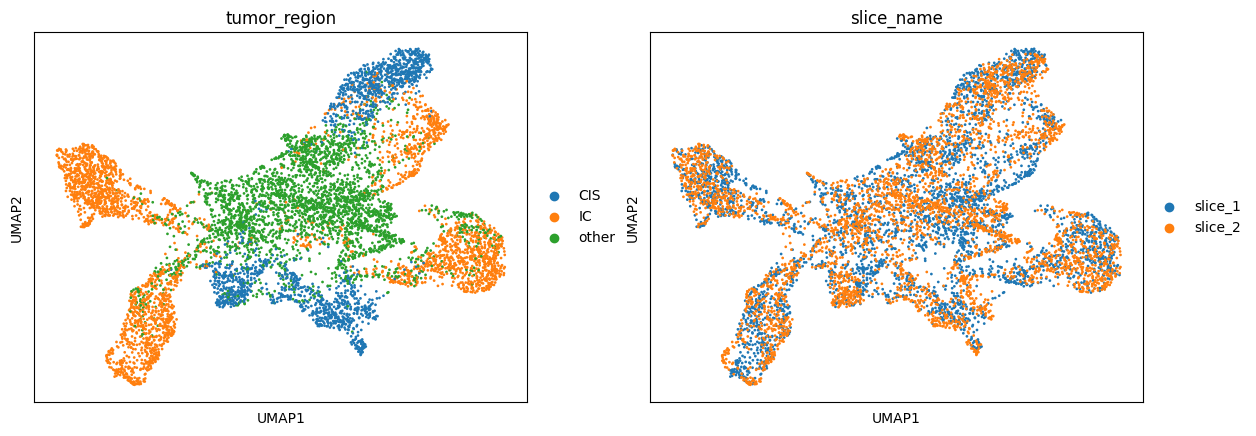

In [6]:
sc.pl.umap(adata_com, color= ['tumor_region','slice_name'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


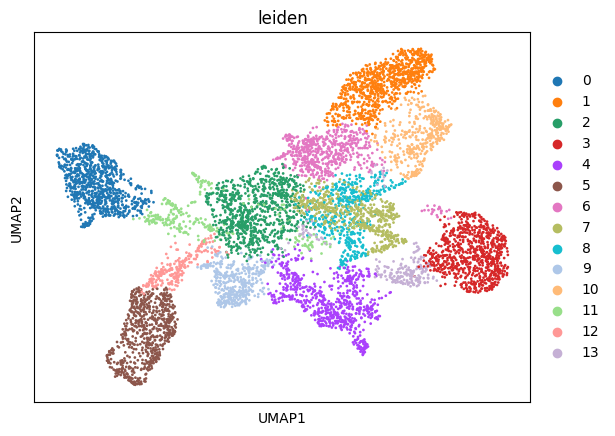

14

In [7]:
sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks', random_state= 666)
sc.tl.leiden(adata_com, resolution=0.67)

sc.pl.umap(adata_com, color=['leiden'])
len(adata_com.obs.leiden.cat.categories)

In [8]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

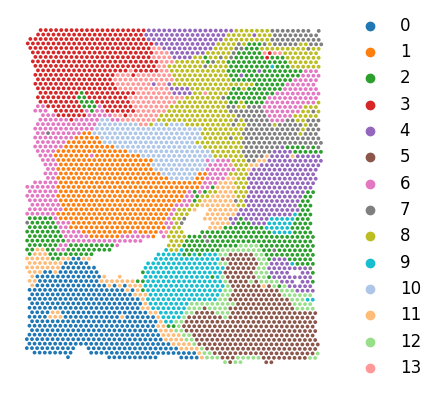

In [9]:
sc.pl.spatial(adata_com[0:3987,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

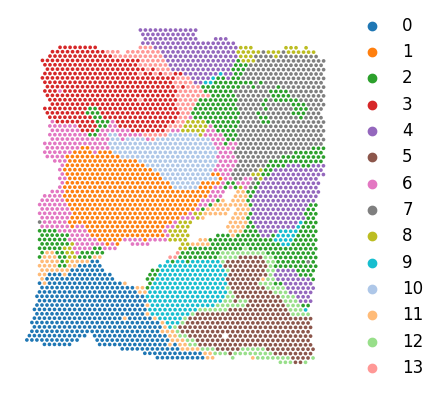

In [10]:
sc.pl.spatial(adata_com[3987:7785,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [11]:
subset_adata = adata_com[adata_com.obs['leiden'].isin(['5', '12'])]

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


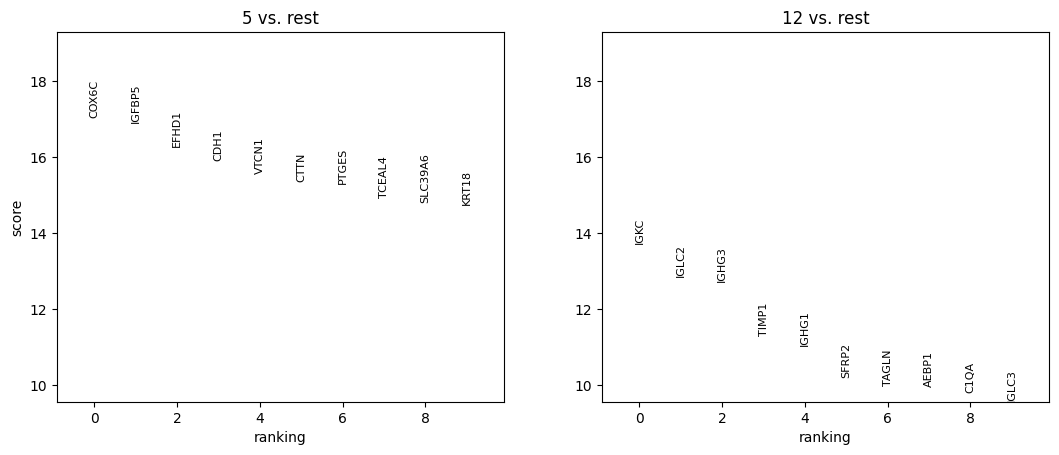

In [ ]:
sc.tl.rank_genes_groups(subset_adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=10)

In [13]:
High_12_results = sc.get.rank_genes_groups_df(subset_adata, group='12')
High_12_results['-log10(pvals)'] = -np.log10(High_12_results['pvals'])
High_12_results.loc[(High_12_results['logfoldchanges']>1)&(High_12_results['pvals']<0.05), 'type'] = 'up'
High_12_results.loc[(High_12_results['logfoldchanges']<-1)&(High_12_results['pvals']<0.05), 'type'] = 'down'
High_12_results.loc[ (abs(High_12_results['logfoldchanges'])<=1) | (High_12_results['pvals']>=0.05), 'type'] = 'nosig'

High_12_results.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,-log10(pvals),type
0,IGKC,13.728986,184.662933,6.807947e-43,8.037989e-40,42.166984,up
1,IGLC2,12.866336,47.620789,6.962788e-38,4.719352e-35,37.157217,up
2,IGHG3,12.730662,109.189140,3.994370e-37,2.396687e-34,36.398552,up
3,TIMP1,11.291799,9.364476,1.440579e-29,3.905678e-27,28.841463,up
4,IGHG1,11.048312,36.986313,2.233750e-28,5.109842e-26,27.650966,up
5,SFRP2,10.186097,4.911110,2.287652e-24,3.474289e-22,23.640610,up
6,TAGLN,9.982659,5.165983,1.815349e-23,2.497879e-21,22.741040,up
7,AEBP1,9.947834,7.526051,2.577313e-23,3.533042e-21,22.588833,up
8,C1QA,9.798811,4.569624,1.139186e-22,1.468146e-20,21.943405,up
9,IGLC3,9.567658,8.862311,1.093543e-21,1.239156e-19,20.961164,up


In [18]:
High_12_results['names'].head(10)

0     IGKC
1    IGLC2
2    IGHG3
3    TIMP1
4    IGHG1
5    SFRP2
6    TAGLN
7    AEBP1
8     C1QA
9    IGLC3
Name: names, dtype: object

In [14]:
High_5_results = sc.get.rank_genes_groups_df(subset_adata, group='5')
High_5_results.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,COX6C,17.054073,261.958557,3.260063e-65,1.193216e-60
1,IGFBP5,16.907661,157.848923,3.950782e-64,7.230129e-60
2,EFHD1,16.285305,11.137061,1.255019e-59,1.531165e-55
3,CDH1,15.909482,12.178855,5.446182e-57,4.983393e-53
4,VTCN1,15.558618,7.894378,1.390693e-54,1.018015e-50
5,CTTN,15.361275,18.412441,2.976629e-53,1.815793e-49
6,PTGES,15.295397,6.425548,8.205873e-53,4.290617e-49
7,TCEAL4,14.948015,28.014019,1.604607e-50,7.341277e-47
8,SLC39A6,14.814083,16.473106,1.187993e-49,4.831302e-46
9,KRT18,14.747625,70.817047,3.186840e-49,1.166415e-45


In [19]:
High_5_results['names'].head(10)

0      COX6C
1     IGFBP5
2      EFHD1
3       CDH1
4      VTCN1
5       CTTN
6      PTGES
7     TCEAL4
8    SLC39A6
9      KRT18
Name: names, dtype: object

p = 2.027e-18
p = 3.218e-19
p = 2.117e-16


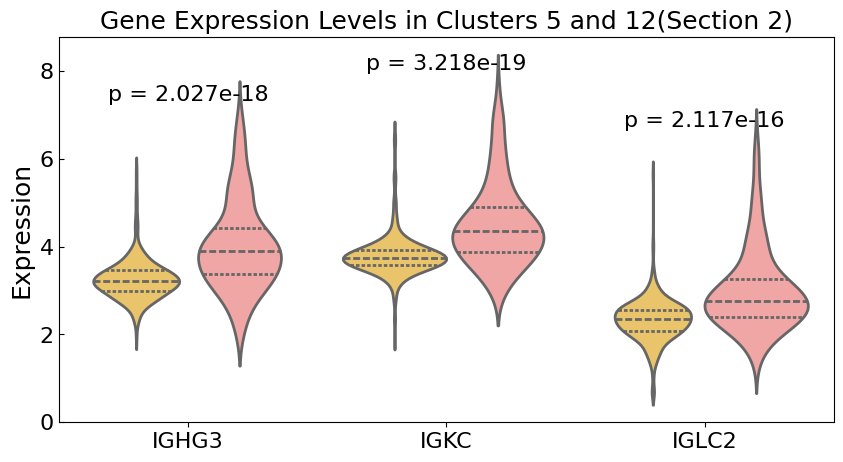

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']

selected_cells = adata_1[adata_1.obs['leiden'].isin(clusters_of_interest)]

expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values 

expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))


plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile', 
                    palette={'5': "#FFCD56", '12': "#FB9A99"}, linewidth=2)
ax.set_xlabel('', fontsize=0) 
ax.set_ylabel('Expression', fontsize=18) 
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, direction='in')
ax.get_legend().remove()
for i, (gene, p_value) in enumerate(p_values):
    p_text = f"p = {p_value:.3e}" 
    print(p_text)
    ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, p_text, 
            ha='center', color='black', fontsize=16)

plt.title('Gene Expression Levels in Clusters 5 and 12(Section 2)', fontsize=18)
plt.show()

p = 1.768e-20
p = 2.240e-25
p = 4.906e-23


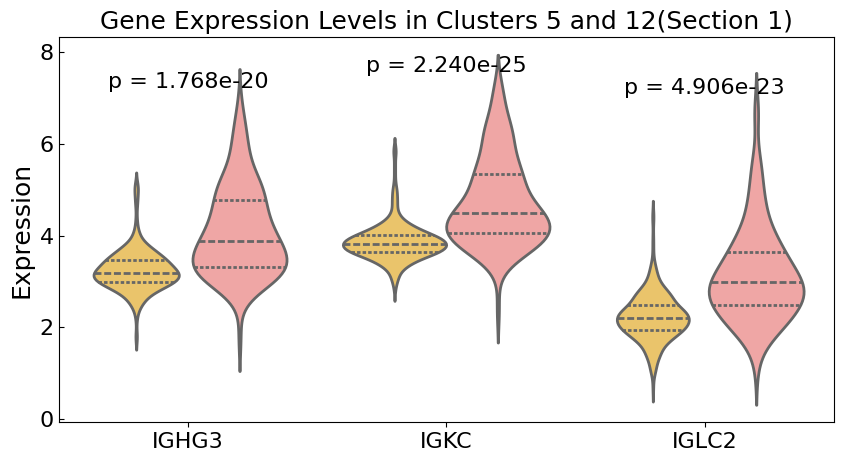

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

clusters_of_interest = ['12', '5']
genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']

selected_cells = adata_2[adata_2.obs['leiden'].isin(clusters_of_interest)]

expression_data = selected_cells[:, genes_of_interest].to_df()
expression_data[genes_of_interest] = expression_data[genes_of_interest].apply(np.log1p)
expression_data['cluster'] = selected_cells.obs['leiden'].values

expression_data = pd.melt(expression_data, id_vars='cluster', var_name='gene', value_name='expression')

p_values = []
for gene in genes_of_interest:
    data_5 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '5')]['expression']
    data_12 = expression_data[(expression_data['gene'] == gene) & (expression_data['cluster'] == '12')]['expression']
    _, p_value = mannwhitneyu(data_5, data_12)
    p_values.append((gene, p_value))

plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='gene', y='expression', hue='cluster', data=expression_data, inner='quartile', 
                    palette={'5': "#FFCD56", '12': "#FB9A99"}, linewidth=2)
ax.set_xlabel('', fontsize=0) 
ax.set_ylabel('Expression', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, direction='in')
ax.get_legend().remove()

for i, (gene, p_value) in enumerate(p_values):
    p_text = f"p = {p_value:.3e}"
    print(p_text)
    ax.text(i, max(expression_data[expression_data['gene'] == gene]['expression']) * 1.05, p_text, 
            ha='center', color='black', fontsize=16)

plt.title('Gene Expression Levels in Clusters 5 and 12(Section 1)', fontsize=18)
plt.show()

In [112]:
Batch_list = [adata_1, adata_2]

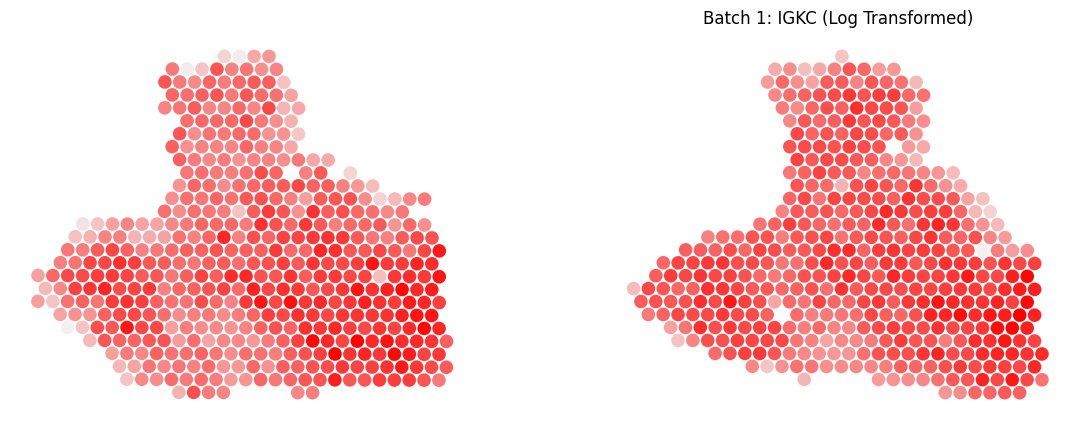

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene_of_interest = 'IGFBP5'
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='')

sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
plt.show()


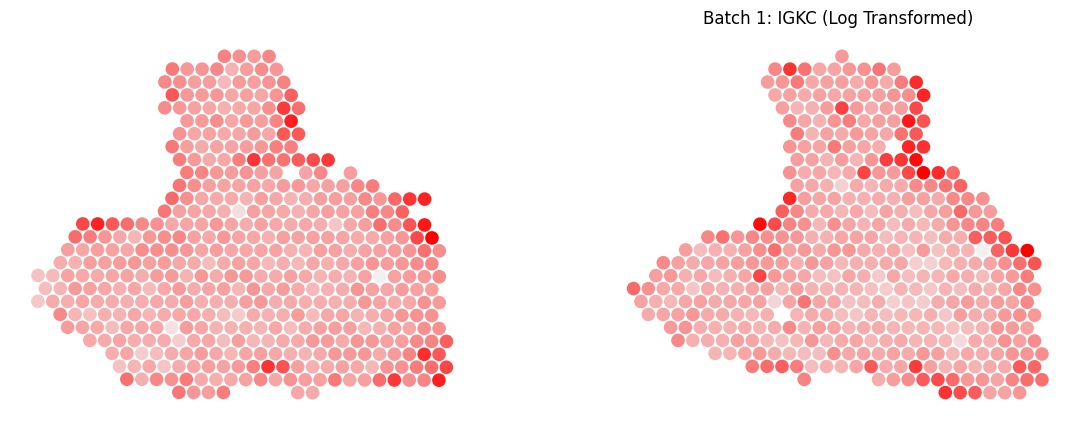

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene_of_interest = 'IGKC'
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='')

sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
plt.show()

In [144]:
adata_com.obs['slice_name']

AAACAACGAATAGTTC-1    slice_1
AAACAAGTATCTCCCA-1    slice_1
AAACAATCTACTAGCA-1    slice_1
AAACACCAATAACTGC-1    slice_1
AAACAGAGCGACTCCT-1    slice_1
                       ...   
TTGTTGTGTGTCAAGA-1    slice_2
TTGTTTCACATCCAGG-1    slice_2
TTGTTTCATTAGTCTA-1    slice_2
TTGTTTCCATACAACT-1    slice_2
TTGTTTGTGTAAATTC-1    slice_2
Name: slice_name, Length: 7785, dtype: category
Categories (2, object): ['slice_1', 'slice_2']

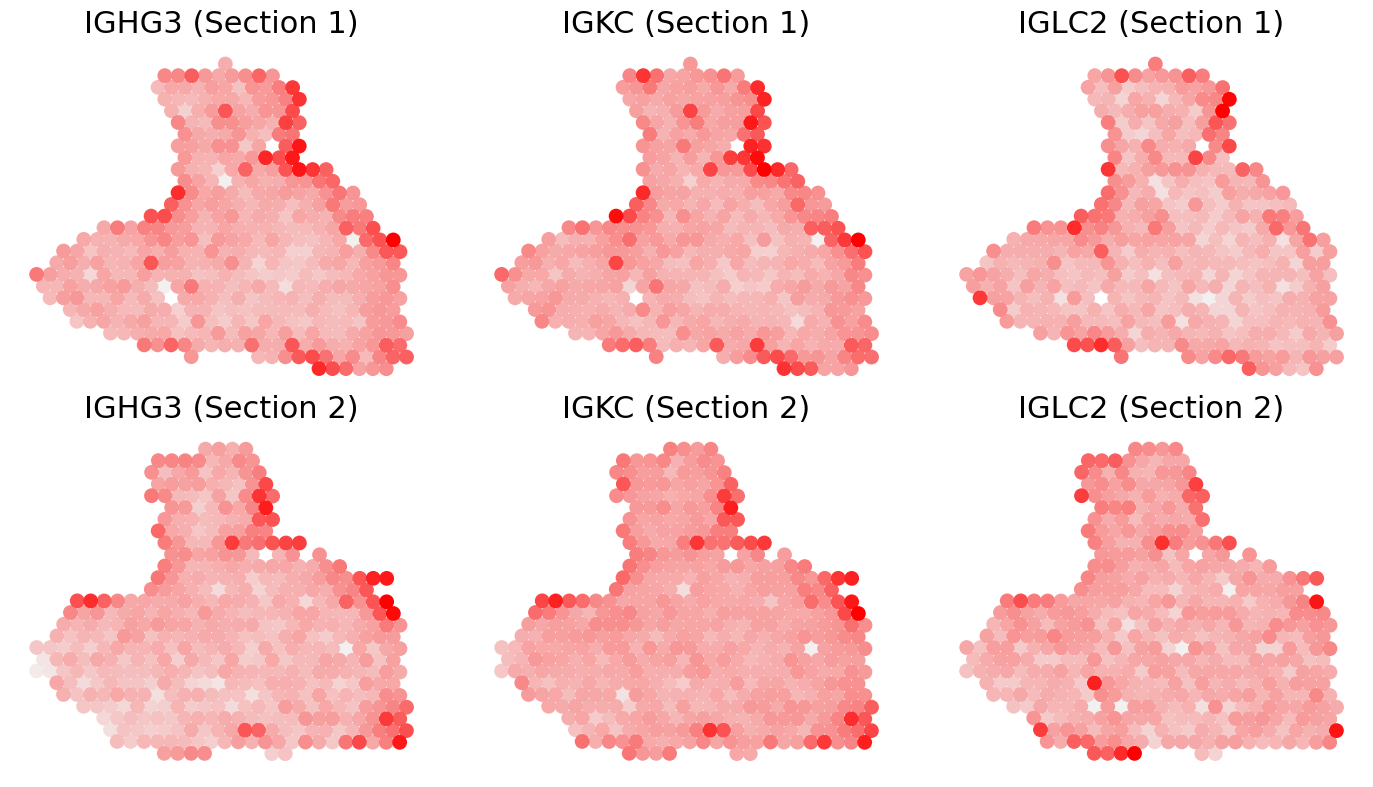

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

genes_of_interest = ['IGHG3', 'IGKC', 'IGLC2']
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

for gene in genes_of_interest:
    if gene not in Batch_list[0].var_names or gene not in Batch_list[1].var_names:
        print(f"Gene {gene} not found in one of the datasets.")
        exit()

for gene in genes_of_interest:
    Batch_list[0].obs[gene + '_log'] = np.log1p(Batch_list[0][:, gene].X.toarray().flatten())
    Batch_list[1].obs[gene + '_log'] = np.log1p(Batch_list[1][:, gene].X.toarray().flatten())

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'wspace': 0, 'hspace': 0})

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(batch_1_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[0, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[0, i].set_title(f'{gene} (Section 1)', fontsize=22)
    sc.pl.spatial(batch_0_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[1, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[1, i].set_title(f'{gene} (Section 2)', fontsize=22)

for cax in [ax[0, i].collections[-1].colorbar.ax for i in range(3)] + [ax[1, i].collections[-1].colorbar.ax for i in range(3)]:
    cax.remove()
plt.show()

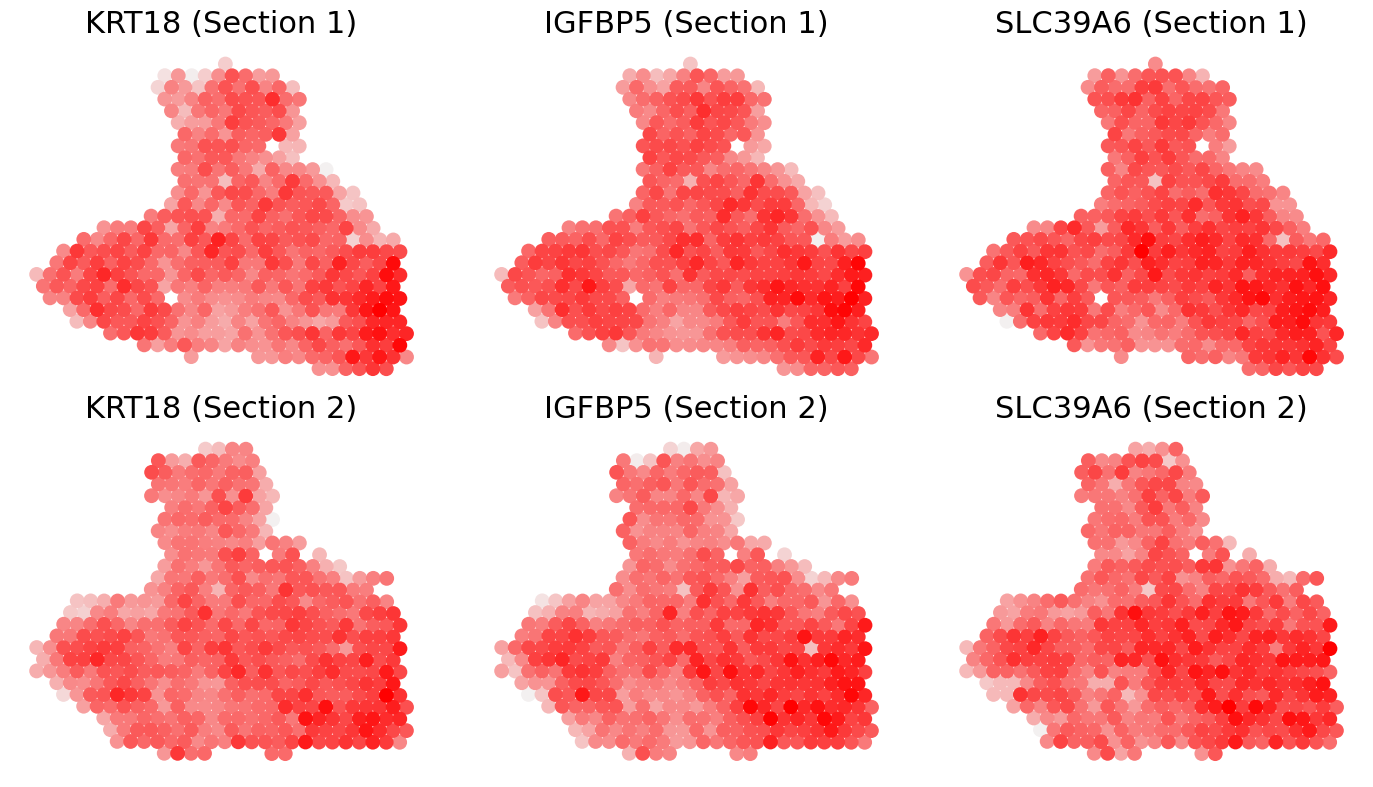

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

genes_of_interest = ['KRT18', 'IGFBP5', 'SLC39A6']
clusters_of_interest = ['5', '12']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

for gene in genes_of_interest:
    if gene not in Batch_list[0].var_names or gene not in Batch_list[1].var_names:
        print(f"Gene {gene} not found in one of the datasets.")
        exit()
for gene in genes_of_interest:
    Batch_list[0].obs[gene + '_log'] = np.log1p(Batch_list[0][:, gene].X.toarray().flatten())
    Batch_list[1].obs[gene + '_log'] = np.log1p(Batch_list[1][:, gene].X.toarray().flatten())
batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'wspace': 0, 'hspace': 0})

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(batch_1_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[0, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[0, i].set_title(f'{gene} (Section 1)', fontsize=22)
    sc.pl.spatial(batch_0_selected, img_key=None, color=gene + '_log', cmap=cmap, 
                  legend_fontsize=20, show=False, ax=ax[1, i], frameon=False, 
                  spot_size=300, legend_loc=None)
    ax[1, i].set_title(f'{gene} (Section 2)', fontsize=22)

for cax in [ax[0, i].collections[-1].colorbar.ax for i in range(3)] + [ax[1, i].collections[-1].colorbar.ax for i in range(3)]:
    cax.remove()
plt.show()

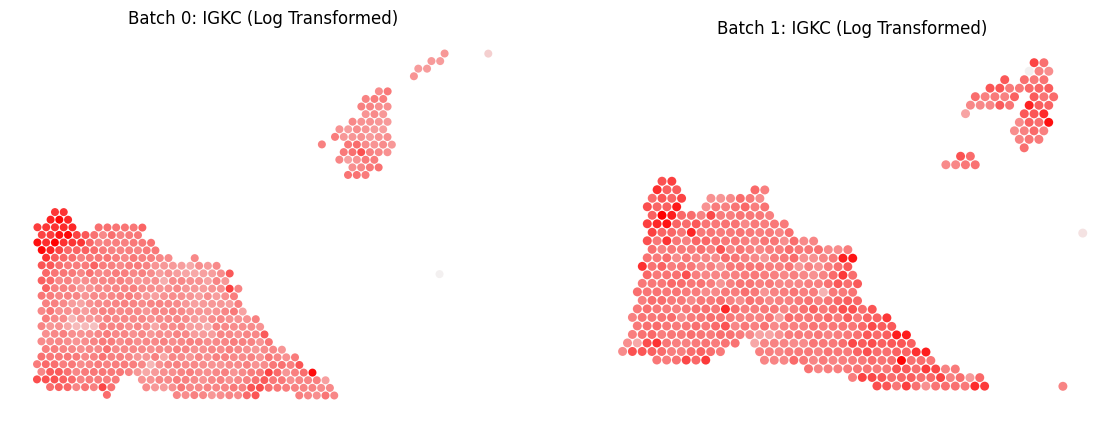

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene_of_interest = 'IGKC'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='Batch 0: IGKC (Log Transformed)')

sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
plt.show()


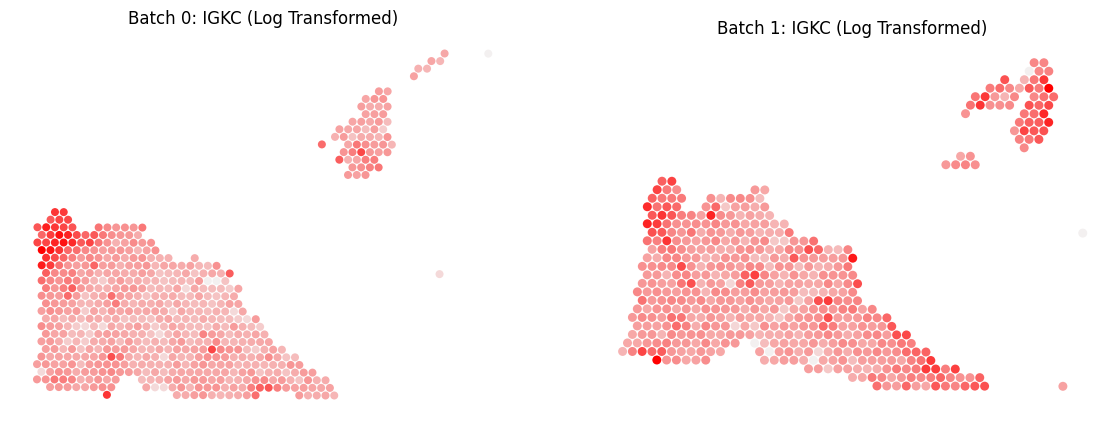

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene_of_interest = 'IGLC2'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='Batch 0: IGKC (Log Transformed)')

sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='Batch 1: IGKC (Log Transformed)')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
plt.show()


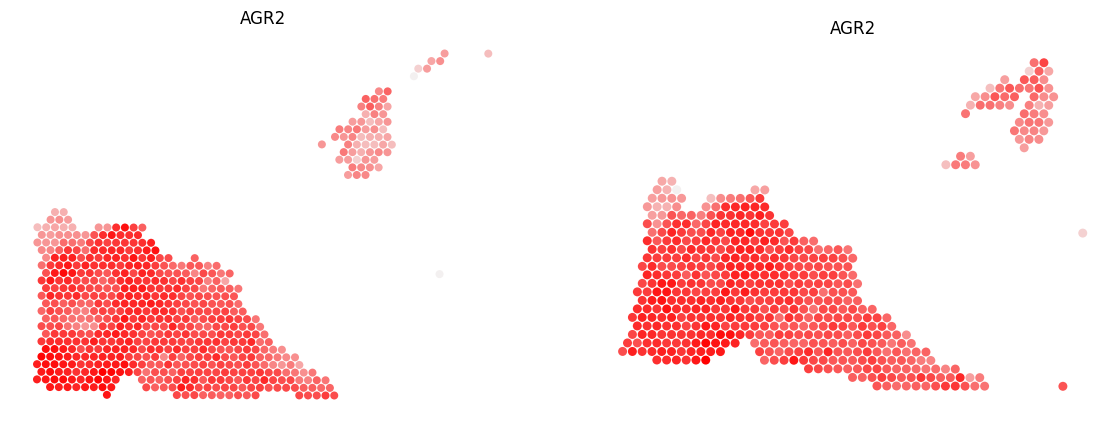

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene_of_interest = 'AGR2'
clusters_of_interest = ['0', '11']
cmap = sns.light_palette("red", n_colors=100, as_cmap=True)

if gene_of_interest in Batch_list[0].var_names and gene_of_interest in Batch_list[1].var_names:
    Batch_list[0].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[0][:, gene_of_interest].X.toarray().flatten())
    Batch_list[1].obs[gene_of_interest + '_log'] = np.log1p(Batch_list[1][:, gene_of_interest].X.toarray().flatten())
else:
    print(f"Gene {gene_of_interest} not found in one of the datasets.")
    exit()

batch_0_selected = Batch_list[0][Batch_list[0].obs['leiden'].isin(clusters_of_interest)]
batch_1_selected = Batch_list[1][Batch_list[1].obs['leiden'].isin(clusters_of_interest)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': 0.05})

sc.pl.spatial(batch_0_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[0], frameon=False, cmap = cmap, 
              legend_loc = None, 
              spot_size=250, title='AGR2')

sc.pl.spatial(batch_1_selected, img_key=None, color=gene_of_interest + '_log',
              legend_fontsize=12, show=False, ax=ax[1], frameon=False, cmap = cmap,
              legend_loc = None, 
              spot_size=250, title='AGR2')

for cax in [ax[0].collections[-1].colorbar.ax, ax[1].collections[-1].colorbar.ax]:
    cax.remove()
plt.show()
